In [65]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import json
import torchvision.utils
import torch.nn as nn
from tqdm import tqdm
from torchvision import models as torch_models
from fgsm import fgsm_attack
import torch
from utils import image_folder_dataset, imshow, get_list_from_dataloader

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = ([class_idx[str(k)][1] for k in range(len(class_idx))])
idx2label[:5]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

In [4]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [43]:
imgnet_dataset = image_folder_dataset(root = 'data/imagenette2/train/', transform = transform, idx2label = idx2label)

imgnet_dataloader = DataLoader(imgnet_dataset, batch_size=3, shuffle=True)

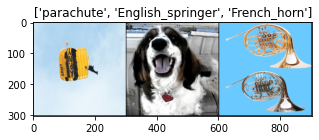

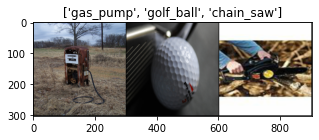

In [44]:
subset = get_list_from_dataloader(imgnet_dataloader,len = 2)
for item in subset:
    images, labels = item
    imshow(torchvision.utils.make_grid(images, normalize=True), [imgnet_dataset.classes[x] for x in labels])

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
model = torch_models.inception_v3(pretrained=True).to(device)

In [69]:
def eval(viz=False, loader=subset):
    print("True Image & Predicted Label")

    model.eval()

    correct = 0
    total = 0
    batch_size = imgnet_dataloader.batch_size
    
    for images, labels in tqdm(loader,total=int(len(imgnet_dataset) / batch_size)):
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, pre = torch.max(outputs.data, 1)
        
        total += 1 
        correct += (pre == labels).sum()
        if viz:
            imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [imgnet_dataset.classes[i] for i in pre])
            
    print('Accuracy of test text: %f %%' % (100 * float(correct) / total / batch_size))

  0%|          | 0/3156 [00:00<?, ?it/s]True Image & Predicted Label


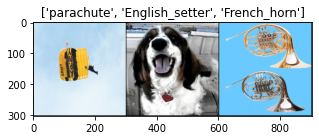

  0%|          | 1/3156 [00:00<23:30,  2.24it/s]

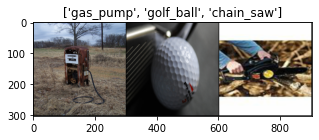

  0%|          | 2/3156 [00:00<21:54,  2.40it/s]Accuracy of test text: 83.333333 %



In [70]:
eval(viz=True, loader=subset)

In [71]:
eval(viz=False, loader=imgnet_dataloader)

  3%|▎         | 108/3156 [00:30<14:15,  3.56it/s]


KeyboardInterrupt: 

In [51]:
eps = 0.007
attack_times = 10

In [49]:
loss = nn.CrossEntropyLoss()

Attack Image & Predicted Label


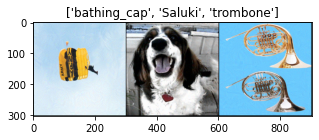

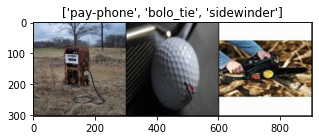

Accuracy of test text: 0.000000 %
Avg attack time is: 3.500000 


In [52]:
def attack(viz=False):
    print("Attack Image & Predicted Label")

    model.eval()

    correct = 0
    total = 0
    attack_total = 0
    for images, labels in subset:
        count = 0
        for t in range(attack_times):        
            images = fgsm_attack(model, loss, images, labels, eps, device).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, pre = torch.max(outputs.data, 1)
            count += 1
            if (pre == labels).sum() == 0:
                break
        else:
            print('unbreakable')
        attack_total += t + 1
        correct += (pre == labels).sum()
        total += 1
        if viz:
            imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True),[imgnet_dataset.classes[i] for i in pre])
        
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total / imgnet_dataloader.batch_size))
print('Avg attack time is: %f ' % (attack_total / total) )